In [2]:
import sys
sys.path.append('/cephfs/home/lc865/workspace/similar-expressions/src/SR_benchmarking')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import json
from tqdm import tqdm
import seaborn as sns

from utils import load_mutations_data, load_neural_stats, load_tensorboard_data, collect_sweep_results

Setting PYTHON_JULIAPKG_PROJECT to /cephfs/home/lc865/workspace/similar-expressions
Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


## Re-onboarding mid-August

In [1]:
338014 - 322883

15131

In [ ]:
{   
    # neural_mutate_tree:
        "total_attempts": 13932,

        "module_not_enabled": 0,
        "no_subtree_found": 2444,
        # sample_routine()
        "sample_routine_failures": 3083,
        "successful_mutations": 8405,
        
    # -----------

    # sample_routine:
        "encoding_failures": 0,

        # resample loop
        "total_samples": 589288,

            "skeleton_not_novel": 7,
            "decoding_failures": 0,

            # if univariate:
                # prods_to_tree()
                # check_expr_similarity
            # else:
                # multivariate_decoding()

            "tree_build_failures": 395873,  # prods_to_tree() or multivariate_decoding()
            "tree_comparison_failures": 147214  # tree size similarity
            
            "expr_similarity_failures": 38718, # <- will decode another expression


        "returned_similar_exprs": 7476,  # <- either one is true if we have a successfull mutation
        "returned_nonsimilar_exprs": 929,

    # -----------

    # multivariate_decoding:

        # feature combination loop
        "multivardec_attempts": 322883,

        "multivardec_totree_failures": 57859,  # prods_to_tree

        "multivardec_similarity_failures": 338014,
        
    # -----------
    
    # check_expr_similarity:
        
    "new_tree_eval_failures": 11130,
    "orig_tree_eval_failures": 60486,
    
    
    
    
}

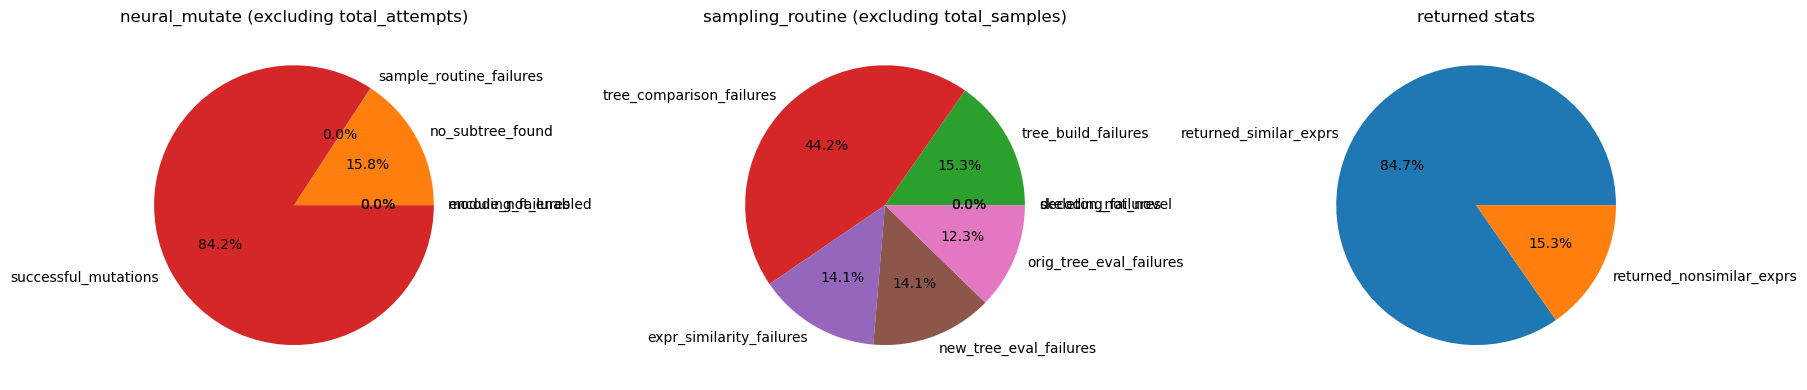

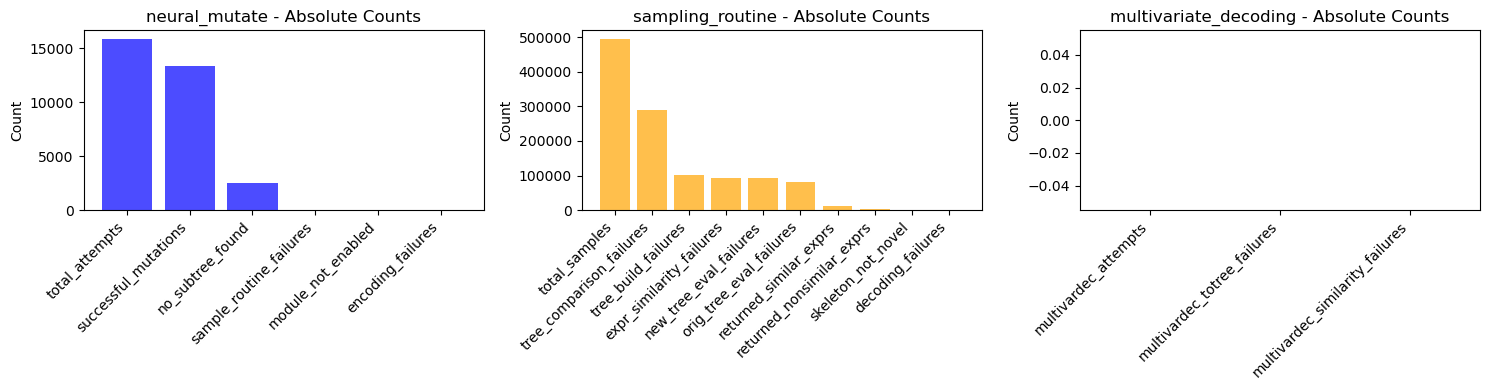

In [16]:
import json
import matplotlib.pyplot as plt

with open('/cephfs/home/lc865/workspace/similar-expressions/src/SR_benchmarking/run/logs/test_univar/neural_stats.json', 'r') as f:
    stats = json.load(f)

# Get counts for each stat type
count_stats = {k: v for k, v in stats.items() if isinstance(v, int)}


using_multivariate = False

stat_categories = {
    'neural_mutate': [
        'total_attempts', 'module_not_enabled', 'no_subtree_found', 'sample_routine_failures', 'successful_mutations', 'encoding_failures'
    ],
    'sampling_routine': [
        'total_samples', 'skeleton_not_novel', 'decoding_failures', 'tree_build_failures', 'tree_comparison_failures', 'expr_similarity_failures',
        'returned_similar_exprs', 'returned_nonsimilar_exprs'
    ],
    'multivariate_decoding': [
        'multivardec_attempts', 'multivardec_totree_failures', 'multivardec_similarity_failures'
    ],
}

key = 'sampling_routine' if not using_multivariate else 'multivariate_decoding'
stat_categories[key].extend(['new_tree_eval_failures', 'orig_tree_eval_failures'])

plot_categories = ['neural_mutate', 'sampling_routine']
if using_multivariate:
    plot_categories.append('multivariate_decoding')

# Special handling for sampling_routine to separate returned_ categories
if 'sampling_routine' in plot_categories:
    # Create subplots: one for each category + extra for sampling_routine returned stats
    total_subplots = len(plot_categories) + 1  # +1 for returned stats
    fig, axes = plt.subplots(1, total_subplots, figsize=(6 * total_subplots, 4))
    if total_subplots == 1:
        axes = [axes]
    
    subplot_idx = 0
    for i, cat in enumerate(plot_categories):
        if cat == 'sampling_routine':
            # First subplot: sampling_routine without returned_ stats
            keys_present = [k for k in stat_categories[cat] if k in count_stats and not k.startswith('returned_')]
            # Exclude 'total_samples' from pie chart
            pie_keys = [k for k in keys_present if k != 'total_samples']
            pie_values = [count_stats[k] for k in pie_keys]
            
            if pie_values:
                axes[subplot_idx].pie(pie_values, labels=pie_keys, autopct='%1.1f%%')
                axes[subplot_idx].set_title(f'{cat} (excluding total_samples)')
            subplot_idx += 1
            
            # Second subplot: returned_ stats only
            returned_keys = [k for k in stat_categories[cat] if k in count_stats and k.startswith('returned_')]
            returned_values = [count_stats[k] for k in returned_keys]
            
            if returned_values:
                axes[subplot_idx].pie(returned_values, labels=returned_keys, autopct='%1.1f%%')
                axes[subplot_idx].set_title('returned stats')
            subplot_idx += 1
        else:
            # Regular categories
            keys_present = [k for k in stat_categories[cat] if k in count_stats]
            # For neural_mutate, exclude 'total_attempts' from pie chart
            if cat == 'neural_mutate':
                pie_keys = [k for k in keys_present if k != 'total_attempts']
            else:
                pie_keys = keys_present
            pie_values = [count_stats[k] for k in pie_keys]
            
            if pie_values:
                axes[subplot_idx].pie(pie_values, labels=pie_keys, autopct='%1.1f%%')
                title_suffix = ' (excluding total_attempts)' if cat == 'neural_mutate' else ''
                axes[subplot_idx].set_title(f'{cat}{title_suffix}')
            subplot_idx += 1
else:
    # No sampling_routine case
    fig, axes = plt.subplots(1, len(plot_categories), figsize=(6 * len(plot_categories), 4))
    if len(plot_categories) == 1:
        axes = [axes]
    
    for i, cat in enumerate(plot_categories):
        keys_present = [k for k in stat_categories[cat] if k in count_stats]
        # Exclude total-type keys from pie charts
        if cat == 'neural_mutate':
            pie_keys = [k for k in keys_present if k != 'total_attempts']
        elif cat == 'multivariate_decoding':
            pie_keys = [k for k in keys_present if k != 'multivardec_attempts']
        else:
            pie_keys = keys_present
        pie_values = [count_stats[k] for k in pie_keys]
        
        if pie_values:
            axes[i].pie(pie_values, labels=pie_keys, autopct='%1.1f%%')
            title_suffix = ''
            if cat == 'neural_mutate':
                title_suffix = ' (excluding total_attempts)'
            elif cat == 'multivariate_decoding':
                title_suffix = ' (excluding multivardec_attempts)'
            axes[i].set_title(f'{cat}{title_suffix}')

plt.tight_layout()
plt.show()

# Second plot: Bar chart showing absolute numbers for each category separately
num_categories = len([cat for cat in stat_categories if any(k in count_stats for k in stat_categories[cat])])
cols = min(3, num_categories)
rows = (num_categories + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
if num_categories == 1:
    axes = [axes]
elif rows == 1 and cols > 1:
    axes = axes
else:
    axes = axes.flatten()

# Colors for different categories
category_colors = {
    'neural_mutate': 'blue',
    'sampling_routine': 'orange', 
    'multivariate_decoding': 'green',
    'other': 'gray'
}

subplot_idx = 0
for cat in stat_categories:
    keys_present = [k for k in stat_categories[cat] if k in count_stats]
    if keys_present:
        values = [count_stats[k] for k in keys_present]
        color = category_colors.get(cat, 'gray')
        
        # Sort by value for better visualization
        sorted_data = sorted(zip(keys_present, values), key=lambda x: x[1], reverse=True)
        sorted_keys, sorted_values = zip(*sorted_data)
        
        # Handle the case where axes might be a single axis object
        if num_categories == 1:
            ax = axes[0]
        else:
            ax = axes[subplot_idx]
            
        ax.bar(range(len(sorted_keys)), sorted_values, color=color, alpha=0.7)
        ax.set_xticks(range(len(sorted_keys)))
        ax.set_xticklabels(sorted_keys, rotation=45, ha='right')
        ax.set_ylabel('Count')
        ax.set_title(f'{cat} - Absolute Counts')
        
        subplot_idx += 1

# Hide any unused subplots
if num_categories > 1:
    for i in range(subplot_idx, len(axes)):
        axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [7]:
path_logdir = '/cephfs/home/lc865/workspace/similar-expressions/src/SR_benchmarking/run/logs/test'
df = load_mutations_data(path_logdir)
df['loss_ratio'] = df['loss_after'] / df['loss_before']
df['is_inf'] = np.isinf(df.score_after) | np.isinf(df.loss_after)

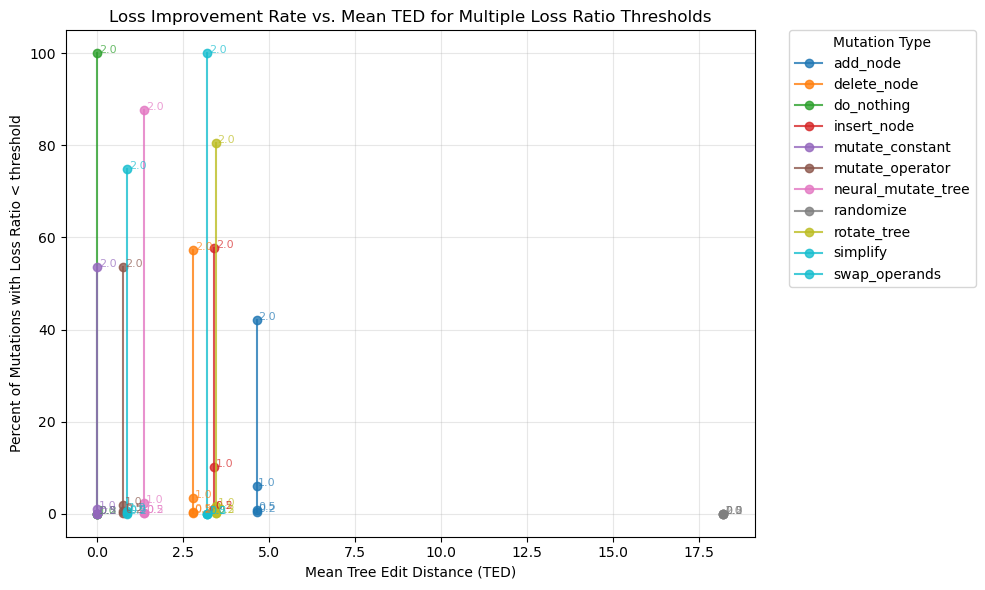

In [23]:
# Calculate mean TED for each mutation type
mean_ted = df[~df.is_inf].groupby('mutation_type')['TED'].mean()

# Plot for multiple loss ratio thresholds and connect the dots for each mutation type

loss_ratio_thresholds = [0.2, 0.5, 1, 2]

# Prepare a DataFrame to collect results for all thresholds
results = []

for thresh in loss_ratio_thresholds:
    loss_metric = df[~df.is_inf].groupby('mutation_type')['loss_ratio'].apply(
        lambda x: (x < thresh).mean() * 100
    )
    # Store for each mutation type and threshold
    for mut_type, val in loss_metric.items():
        results.append({'mutation_type': mut_type, 'loss_ratio_threshold': thresh, 'lossImprovRate': val})

results_df = pd.DataFrame(results)

# Merge with mean TED for each mutation type
mean_ted_df = mean_ted.reset_index().rename(columns={'TED': 'mean_TED'})
plot_df = results_df.merge(mean_ted_df, left_on='mutation_type', right_on='mutation_type', how='left')

# Get unique mutation types and assign colors
mutation_types = plot_df['mutation_type'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(mutation_types)))

plt.figure(figsize=(10, 6))

for i, mut_type in enumerate(mutation_types):
    sub = plot_df[plot_df['mutation_type'] == mut_type]
    # X: mean TED (constant for this mutation type), Y: lossImprovRate, X-axis is mean TED, Y-axis is lossImprovRate for each threshold
    plt.plot([sub['mean_TED'].iloc[0]]*len(loss_ratio_thresholds), sub['lossImprovRate'], 
             marker='o', color=colors[i], label=mut_type, alpha=0.8)
    # Optionally, annotate the points with the threshold value
    for j, row in sub.iterrows():
        plt.text(row['mean_TED']+0.05, row['lossImprovRate'], f"{row['loss_ratio_threshold']}", fontsize=8, color=colors[i], alpha=0.7)

plt.xlabel('Mean Tree Edit Distance (TED)')
plt.ylabel('Percent of Mutations with Loss Ratio < threshold')
plt.title('Loss Improvement Rate vs. Mean TED for Multiple Loss Ratio Thresholds')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='Mutation Type')
plt.tight_layout()
plt.show()

## Misc old

In [ ]:
path_logdir = '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/variance_tests/feynman_eq1'
df = load_mutations_data(path_logdir)
df['loss_ratio'] = df['loss_after'] / df['loss_before']
df['is_inf'] = np.isinf(df.score_after) | np.isinf(df.loss_after)

In [ ]:
# Calculate histogram for each mutation type using the specified bins
def hist_by_category(df: pd.DataFrame, category_col: str, value_col: str, bins: list, bin_labels: list, plot: bool = True, return_df: bool = False) -> None:
    hist_data = {}
    for cat in df[category_col].unique():
        subset = df[df[category_col] == cat][value_col]
        hist, _ = np.histogram(subset, bins=bins)
        percentages = (hist / len(subset) * 100).round(1)
        hist_data[cat] = percentages

    hist_df2 = pd.DataFrame(hist_data, index=bin_labels).T

    # Create a heatmap with percentages
    if plot:
        plt.figure(figsize=(6, 3))
        heatmap = sns.heatmap(hist_df2, annot=True, cmap="YlGnBu", fmt='.1f', 
                            linewidths=.5, cbar_kws={'label': 'Percentage (%)'}, cbar=False)
        plt.title('Distribution of Loss Difference by Mutation Type')
        plt.ylabel(category_col)
        plt.xlabel(f'Range of {value_col}')
        plt.tight_layout()
    if return_df:
        return hist_df2

hist_by_category(
    df, 
    category_col='mutation_type', 
    value_col='loss_ratio', 
    bins=[-np.inf, 1-1e-12, 1+1e-12, 1.1, 10, np.inf], 
    bin_labels=['< ~1', '~1', '[~1, 1.1]', '[1.1, 10]', '> 10'],
    plot=False,
    return_df=True
)

,< ~1,~1,"[~1, 1.1]","[1.1, 10]",> 10
insert_node,6.4,4.8,4.1,15.5,69.2
rotate_tree,1.1,44.1,3.0,7.7,44.1
mutate_operator,0.7,25.4,1.2,11.3,61.3
neural_mutate_tree,1.8,32.4,2.2,11.5,52.1
do_nothing,0.0,100.0,0.0,0.0,0.0
delete_node,3.9,9.3,3.4,15.4,68.1
add_node,5.4,3.1,2.5,12.8,76.2
randomize,1.7,0.4,0.3,3.0,94.6
swap_operands,0.2,33.5,0.8,3.7,61.8
mutate_constant,3.3,2.3,5.6,25.6,63.1


In [28]:
# Show results reason by mutation count
# Get counts by mutation type and result reason
def result_reason_by_mutation_type(df: pd.DataFrame, ratio: bool = False):
    counts_df = df.groupby('mutation_type')['result_reason'].value_counts().unstack().fillna(0).astype(int)

    # Add sum of each mutation type
    counts_df['sum'] = counts_df.sum(axis=1)

    if not ratio:
        return counts_df
    else:
        ratio_df = (counts_df.div(counts_df['sum'], axis=0)*100).round(1).drop(columns=['sum'])
        return ratio_df

result_reason_by_mutation_type(df, ratio=False)
result_reason_by_mutation_type(df, ratio=True)

result_reason,annealing_or_frequency,failed_constraint_check,pass
mutation_type,,,
add_node,37.0,0.0,63.0
delete_node,16.8,0.0,83.2
do_nothing,0.0,0.0,100.0
insert_node,36.9,0.0,63.1
mutate_constant,0.0,0.0,100.0
mutate_operator,0.0,0.0,100.0
neural_mutate_tree,20.4,0.4,79.2
randomize,33.3,0.0,66.7
rotate_tree,0.0,0.0,100.0


## Variance checks

In [35]:
from tqdm import trange

all_dfs = []
for eq_idx in trange(1, 18):
    path_logdir = f'/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/initial_variance_tests/synthetic_eq{eq_idx}'
    df = load_mutations_data(path_logdir)
    df['loss_ratio'] = df['loss_after'] / df['loss_before']

    all_dfs.append(hist_by_category(
        df, 
        category_col='mutation_type', 
        value_col='loss_ratio', 
        bins=[-np.inf, 2, np.inf],  # [-np.inf, 1-1e-12, 1+1e-12, 1.1, 10, np.inf], 
        bin_labels=['< 2', '> 2'],  # ['< ~1', '~1', '[~1, 1.1]', '[1.1, 10]', '> 10'],
        plot=False,
        return_df=True
    ).sort_index())
stacked = np.stack([df.values for df in all_dfs])
mean, err = stacked.mean(axis=0), stacked.std(axis=0)/np.sqrt(stacked.shape[0])
display(pd.DataFrame(mean, index=all_dfs[0].index, columns=all_dfs[0].columns).round(1))
display(pd.DataFrame(err, index=all_dfs[0].index, columns=all_dfs[0].columns).round(1))

100%|██████████| 17/17 [00:07<00:00,  2.36it/s]


,< 2,> 2
add_node,55.2,44.8
delete_node,62.0,38.0
do_nothing,100.0,0.0
insert_node,61.1,38.9
mutate_constant,61.6,38.4
mutate_operator,64.2,35.8
neural_mutate_tree,75.0,25.0
randomize,32.0,68.0
rotate_tree,66.4,33.6
simplify,100.0,0.0


,< 2,> 2
add_node,4.0,4.0
delete_node,3.1,3.1
do_nothing,0.0,0.0
insert_node,3.4,3.4
mutate_constant,3.2,3.2
mutate_operator,2.8,2.8
neural_mutate_tree,2.4,2.4
randomize,5.0,5.0
rotate_tree,2.7,2.7
simplify,0.0,0.0


In [34]:
all_dfs = []
for eq_idx in trange(20):
    path_logdir = f'/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/variance_tests/synthetic_eq{eq_idx}'
    df = load_mutations_data(path_logdir)
    df['loss_ratio'] = df['loss_after'] / df['loss_before']

    all_dfs.append(result_reason_by_mutation_type(df, ratio=False).sort_index())

stacked = np.stack([df.values for df in all_dfs])
mean, std = stacked.mean(axis=0), stacked.std(axis=0)
display(pd.DataFrame(mean, index=all_dfs[0].index, columns=all_dfs[0].columns).round(1))
display(pd.DataFrame(std, index=all_dfs[0].index, columns=all_dfs[0].columns).round(1))

100%|██████████| 20/20 [00:04<00:00,  4.23it/s]


result_reason,annealing_or_frequency,failed_constraint_check,pass,sum
mutation_type,,,,
add_node,696.4,0.2,1061.6,1758.2
delete_node,1692.5,0.0,8710.8,10403.2
do_nothing,0.0,0.0,12208.0,12208.0
insert_node,22076.0,3.4,33416.2,55495.6
mutate_constant,0.0,0.0,477.6,477.6
mutate_operator,0.0,0.0,102392.0,102392.0
neural_mutate_tree,6032.2,133.2,22188.2,28353.6
randomize,73.9,0.0,121.6,195.5
rotate_tree,0.0,0.0,40218.8,40218.8


result_reason,annealing_or_frequency,failed_constraint_check,pass,sum
mutation_type,,,,
add_node,38.2,0.6,82.4,96.5
delete_node,162.8,0.0,179.6,145.0
do_nothing,0.0,0.0,182.5,182.5
insert_node,1276.0,2.2,2213.4,2605.9
mutate_constant,0.0,0.0,40.4,40.4
mutate_operator,0.0,0.0,1634.7,1634.7
neural_mutate_tree,449.2,40.7,576.7,416.4
randomize,10.4,0.0,12.0,9.9
rotate_tree,0.0,0.0,534.0,534.0


/tmp/ipykernel_417795/2567962509.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'geo_mean': filtered_df.groupby('mutation_type').apply(
/tmp/ipykernel_417795/2567962509.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'log_transform_mean': filtered_df.groupby('mutation_type').apply(


,median,geo_mean,log_transform_mean,trimmed_mean,winsorized_mean,percent_<1,percent_<5,percent_<10
mutation_type,,,,,,,,
add_node,4.6,10.8,2.7,219.2,119.6,6.1,50.9,55.4
delete_node,1.2,6.0,2.2,107.7,45.4,3.4,62.2,66.0
do_nothing,1.0,1.0,0.7,1.0,1.0,0.0,100.0,100.0
insert_node,1.2,5.0,2.1,41.9,52.3,10.1,65.1,69.7
mutate_constant,1.5,3.0,1.6,13.3,8.9,1.1,79.1,82.5
mutate_operator,1.4,6.4,2.2,46.3,46.2,2.0,59.3,63.2
neural_mutate_tree,1.0,1.5,1.0,2.7,3.5,2.3,90.2,91.8
randomize,2761.1,23159.9,10.1,286428028.2,152859168.7,0.0,0.0,0.0
rotate_tree,1.0,2.2,1.4,15.7,10.7,1.7,83.8,85.9


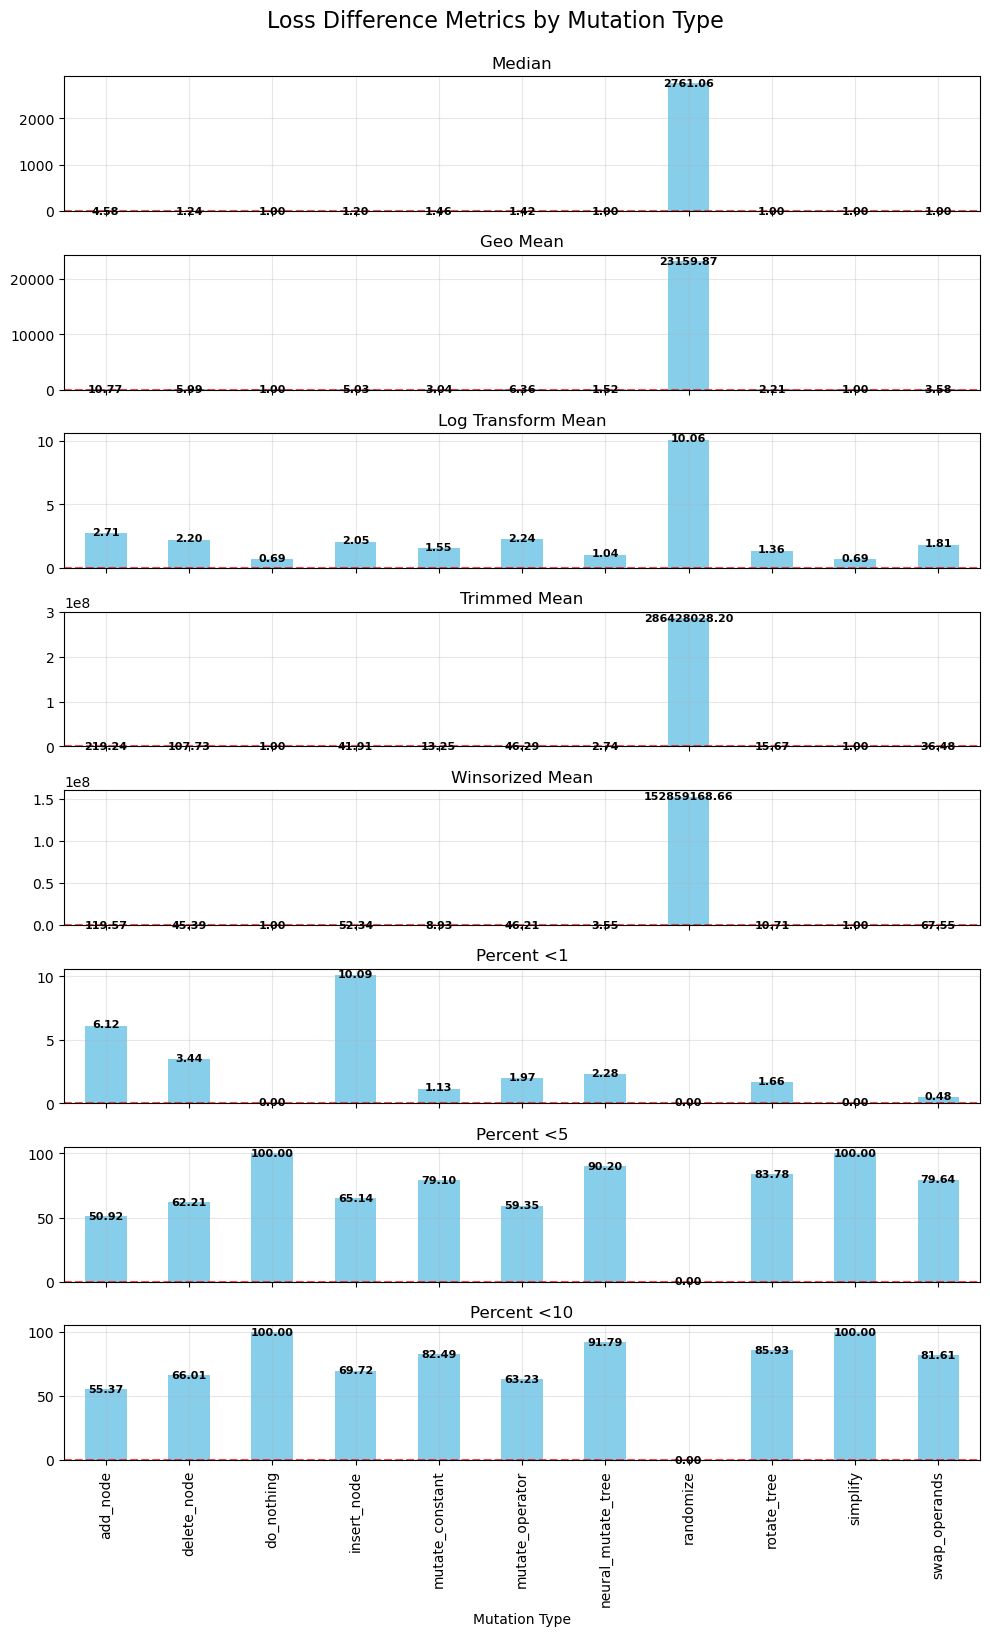

In [10]:
# Filter out infinite values
filtered_df = df[~df.is_inf]

# Group by mutation_type and calculate different metrics
metric = 'loss_ratio'
result = pd.DataFrame({
    'median': filtered_df.groupby('mutation_type')[metric].median(),
    'geo_mean': filtered_df.groupby('mutation_type').apply(
        lambda x: np.exp(np.mean(np.log(np.abs(x[metric]) + 1e-10))) * np.sign(np.mean(x[metric]))
    ),
    'log_transform_mean': filtered_df.groupby('mutation_type').apply(
        lambda x: np.mean(np.sign(x[metric]) * np.log1p(np.abs(x[metric])))
    ),
    'trimmed_mean': filtered_df.groupby('mutation_type')[metric].apply(
        lambda x: np.percentile(x, [10, 90]).mean()  # Alternative way to get trimmed mean
    ),
    'winsorized_mean': filtered_df.groupby('mutation_type')[metric].apply(
        lambda x: np.mean(np.clip(x, np.percentile(x, 5), np.percentile(x, 95)))  # Winsorize at 5th and 95th percentiles
    ),
    'percent_<1': filtered_df.groupby('mutation_type')[metric].apply(
        lambda x: (x < 1).mean() * 100  # Calculate percentage of negative values
    ),
    'percent_<5': filtered_df.groupby('mutation_type')[metric].apply(
        lambda x: (x < 5).mean() * 100  # Calculate percentage of negative values
    ),
    'percent_<10': filtered_df.groupby('mutation_type')[metric].apply(
        lambda x: (x < 10).mean() * 100  # Calculate percentage of negative values
    )
})

# Display the result dataframe
display(result.round(1))

# Create a figure with multiple subplots for different metrics
fig, axes = plt.subplots(len(result.columns), 1, figsize=(10, 16), sharex=True)
metrics = ['median', 'geo_mean', 'log_transform_mean', 'trimmed_mean', 'winsorized_mean', 'percent_<1', 'percent_<5', 'percent_<10']

for i, metric in enumerate(metrics):
    result[metric].plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_title(f'{metric.replace("_", " ").title()}')
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for j, v in enumerate(result[metric]):
        axes[i].text(j, v + (0.1 if v >= 0 else -0.1), 
                    f'{v:.2f}', ha='center', va='center' if v >= 0 else 'top',
                    fontweight='bold', fontsize=8)

plt.tight_layout()
plt.xlabel('Mutation Type')
plt.suptitle('Loss Difference Metrics by Mutation Type', fontsize=16, y=1.02)
plt.show()

### Tree-edit distance

In [11]:
df[['mutation_type', 'TED']].groupby('mutation_type').TED.describe().round(1)

,count,mean,std,min,25%,50%,75%,max
mutation_type,,,,,,,,
add_node,25876.0,4.6,5.8,1.0,1.0,2.0,5.0,36.0
delete_node,11150.0,2.8,5.5,0.0,0.0,0.0,3.0,34.0
do_nothing,3538.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
insert_node,110.0,3.4,4.0,1.0,2.0,2.0,3.0,26.0
mutate_constant,179.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mutate_operator,3794.0,0.8,0.4,0.0,1.0,1.0,1.0,1.0
neural_mutate_tree,12874.0,1.4,2.4,0.0,0.0,0.0,2.0,14.0
randomize,5.0,18.2,8.5,9.0,12.0,16.0,25.0,29.0
rotate_tree,54591.0,3.5,5.2,0.0,0.0,2.0,4.0,40.0


### Combined metrics

In [12]:
# Calculate mean TED for each mutation type
mean_ted = df.groupby('mutation_type')['TED'].mean()

# Calculate percent negative score_diff for each mutation type (excluding infinities)
# Negative score_diff is good (improvement)
percent_smaller_than_01 = df[~df.is_inf].groupby('mutation_type')['loss_diff_norm'].apply(
    lambda x: (x < 1e-3).mean() * 100  # Calculate percentage of negative values
)

# Combine the data
plot_data = pd.DataFrame({
    'TED': mean_ted,
    'lossImprovRate': percent_smaller_than_01
}).dropna()  # Remove any rows with NaN values

# Create scatter plot with color coding
plt.figure(figsize=(8, 5))

# Create a colormap
colors = plt.cm.tab10(np.linspace(0, 1, len(plot_data)))

# Plot each point with a different color
for i, (idx, row) in enumerate(plot_data.iterrows()):
    plt.scatter(row['TED'], row['lossImprovRate'], 
                s=100, alpha=0.8, color=colors[i], label=idx)

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

plt.xlabel('Mean Tree Edit Distance (TED)')
plt.ylabel(f'Percent of Mutations with Normalized\n Loss Difference < {1e-3:.0e}')
plt.grid(True, alpha=0.3)

# Add legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.show()

KeyError: 'Column not found: loss_diff_norm'

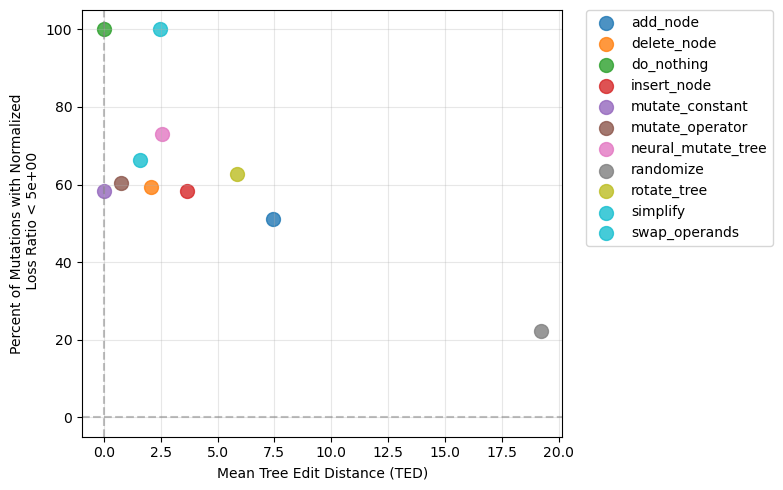

In [81]:
# Calculate mean TED for each mutation type
mean_ted = df.groupby('mutation_type')['TED'].mean()

# Calculate percent negative score_diff for each mutation type (excluding infinities)
# Negative score_diff is good (improvement)
percent_smaller_than_01 = df[~df.is_inf].groupby('mutation_type')['loss_ratio'].apply(
    lambda x: (x < 2).mean() * 100  # Calculate percentage of negative values
)

# Combine the data
plot_data = pd.DataFrame({
    'TED': mean_ted,
    'lossImprovRate': percent_smaller_than_01
}).dropna()  # Remove any rows with NaN values

# Create scatter plot with color coding
plt.figure(figsize=(8, 5))

# Create a colormap
colors = plt.cm.tab10(np.linspace(0, 1, len(plot_data)))

# Plot each point with a different color
for i, (idx, row) in enumerate(plot_data.iterrows()):
    plt.scatter(row['TED'], row['lossImprovRate'], 
                s=100, alpha=0.8, color=colors[i], label=idx)

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

plt.xlabel('Mean Tree Edit Distance (TED)')
plt.ylabel(f'Percent of Mutations with Normalized\n Loss Ratio < {5:.0e}')
plt.grid(True, alpha=0.3)

# Add legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.show()

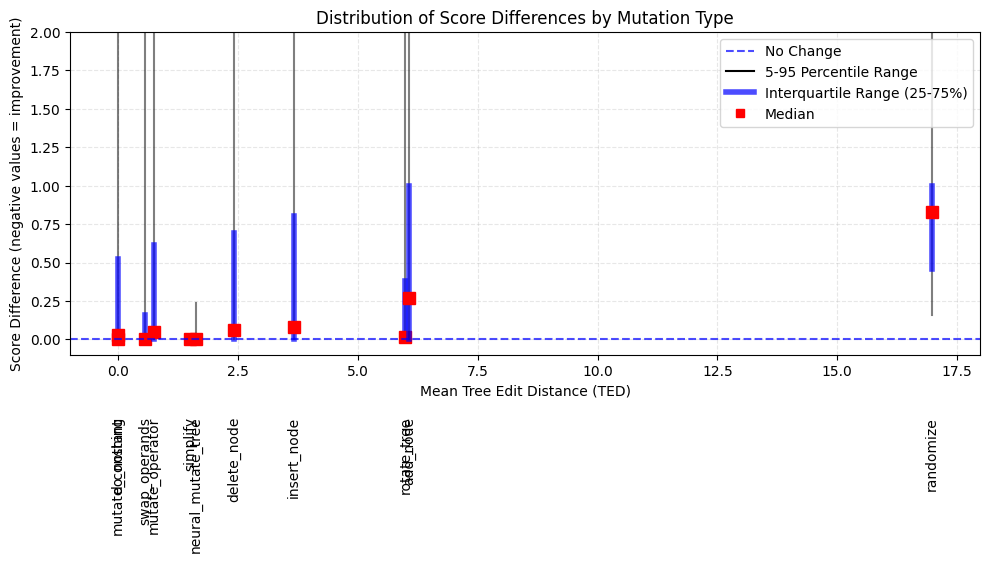

In [25]:
# Create a plot with boxplot-style visualization for each mutation type
# showing median and percentiles of score_diff

# Filter out infinities for better visualization
filtered_df = df[~df.is_inf]

# Calculate statistics for each mutation type
stats = filtered_df.groupby('mutation_type').agg({
    'score_diff': [
        ('median', 'median'),
        ('q25', lambda x: x.quantile(0.25)),
        ('q75', lambda x: x.quantile(0.75)),
        ('min', lambda x: x.quantile(0.05)),  # Using 5th percentile instead of min to avoid outliers
        ('max', lambda x: x.quantile(0.95))   # Using 95th percentile instead of max to avoid outliers
    ],
    'TED': [('mean', 'mean')]  # Add mean TED calculation
}).reset_index()

# Flatten the multi-level columns
stats.columns = ['_'.join(col).strip('_') for col in stats.columns.values]

# Sort by median for better visualization
stats = stats.sort_values('score_diff_median')

# Create the figure
plt.figure(figsize=(10, 6))

# Plot each mutation type as a vertical line with markers
for i, row in enumerate(stats.itertuples()):
    mutation = row.mutation_type
    
    # Use the mean TED as the x position instead of the index
    x_pos = row.TED_mean
    
    # Plot the min-max line (5-95 percentile range)
    plt.plot([x_pos, x_pos], [row.score_diff_min, row.score_diff_max], 'k-', alpha=0.5)
    
    # Plot the interquartile range as a thicker, colored line for better visibility
    plt.plot([x_pos, x_pos], [row.score_diff_q25, row.score_diff_q75], 'b-', linewidth=4, alpha=0.7)
    
    # Plot the median as a distinct marker
    plt.plot(x_pos, row.score_diff_median, 'rs', markersize=8)
    
    # Plot the mean as a square marker
    # plt.plot(x_pos, row.TED_mean, 'gs', markersize=8)
    
    # Add the mutation type label
    plt.text(x_pos, stats['score_diff_min'].min() - 0.5, mutation, ha='center', va='top', rotation=90)

# Add a horizontal line at y=0 to show the boundary between improvement and degradation
plt.axhline(y=0, color='blue', linestyle='--', alpha=0.7, label='No Change')

# Set the x-axis limits to give some padding
plt.xlim(stats['TED_mean'].min() - 1, stats['TED_mean'].max() + 1)

# Add labels and title
plt.xlabel('Mean Tree Edit Distance (TED)')
plt.ylabel('Score Difference (negative values = improvement)')
plt.title('Distribution of Score Differences by Mutation Type')

# Add a legend to explain the plot elements
plt.plot([], [], 'k-', label='5-95 Percentile Range')
plt.plot([], [], 'b-', linewidth=4, alpha=0.7, label='Interquartile Range (25-75%)')
plt.plot([], [], 'rs', label='Median')
# plt.plot([], [], 'gs', label='Mean TED')
plt.legend(loc='best')

# Add grid lines for better readability
plt.grid(linestyle='--', alpha=0.3)

plt.ylim(-0.1, 2)

plt.tight_layout()
plt.show()
